In [1]:
import torch
import numpy as np
import pandas as pd
from itertools import count
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import Image
%matplotlib inline
import os
import shutil

In [2]:
from agent import RelationalQLearningAgent

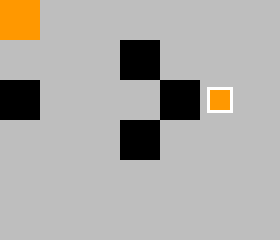

In [3]:
from warehouse_env.warehouse_env import WarehouseEnv
import numpy as np
from tqdm import tqdm

simple_agent = \
         [[ 1,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  0,  0,  0, 0],
          [ 0,  0,  0,  0,  0,  0, 0]]
simple_world = \
         [[  0,  0,  0,  0,  0,  0, 0],
          [  0,  0,  0,  1,  0,  0, 0],
          [  1,  0,  0,  0,  1,  0, 0],
          [  0,  0,  0,  1,  0,  0, 0],
          [  0,  0,  0,  0,  0,  0, 0],
          [  0,  0,  0,  0,  0,  0, 0]]
env = WarehouseEnv(agent_map=np.array(simple_agent), obstacle_map=np.array(simple_world), max_timestep=1000)

env.render(zoom_size=40)

In [4]:
agent = RelationalQLearningAgent(4, 0.99, 128, 0.9, 0.05, 1e8, 1028, channels=5)

In [5]:
device = torch.device('cuda')
target_update = 10
output_dir = "./output"

In [6]:
def warehouse_state_to_tensor(x):
    return transforms.functional.to_tensor(x).unsqueeze(0).double()

In [ ]:
episode_lengths = []
episode_solved = []
episode_cum_rewards = []
try:
    for episode in range(1000):
        state = env.reset()
        state = warehouse_state_to_tensor(state).to(device)
        cum_reward = 0
        for t in count():
            action = agent.action(state)
            next_state, reward, done, meta = env.step(action.item())
            cum_reward += reward
            next_state = warehouse_state_to_tensor(next_state).to(device)
            reward = torch.Tensor([reward]).to(device)
            agent.push_transition(state, action, next_state, reward)
            state = next_state
            agent.optimize()
            if done:
                print(episode, t + 1, reward, meta, done)
                episode_lengths.append(meta["episode"]["length"])
                episode_solved.append(meta["episode"]["solved"])
                break
            # if not episode % target_update:
            if not episode % target_update:
                agent.update_target()
                im = env.render(zoom_size=40)
                output_dir = f"./episode_gifs/ep_{episode}"
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                im.save(os.path.join(output_dir, f"{t}.png"))
                # display.display(im)
                # display.clear_output(wait=True)
            print(episode, t, reward, meta, done)
    episode_cum_rewards.append(cum_reward)
except KeyboardInterrupt:
    pass
df = pd.DataFrame({"length": episode_lengths, "solved": episode_solved, "cum_reward": episode_cum_rewards})
df.to_csv(os.path.join(output_dir, "train_results.csv"), index=False)
torch.save(agent, os.path.join(output_dir, f"agent.pt"))

0 0 tensor([0.], device='cuda:0') {'episode': {'length': 1, 'solved': None}} False
0 1 tensor([0.], device='cuda:0') {'episode': {'length': 2, 'solved': None}} False
0 2 tensor([0.], device='cuda:0') {'episode': {'length': 3, 'solved': None}} False
0 3 tensor([0.], device='cuda:0') {'episode': {'length': 4, 'solved': None}} False
0 4 tensor([0.], device='cuda:0') {'episode': {'length': 5, 'solved': None}} False
0 5 tensor([0.], device='cuda:0') {'episode': {'length': 6, 'solved': None}} False
0 6 tensor([0.], device='cuda:0') {'episode': {'length': 7, 'solved': None}} False
0 7 tensor([0.], device='cuda:0') {'episode': {'length': 8, 'solved': None}} False
0 8 tensor([0.], device='cuda:0') {'episode': {'length': 9, 'solved': None}} False
0 9 tensor([0.], device='cuda:0') {'episode': {'length': 10, 'solved': None}} False
0 10 tensor([0.], device='cuda:0') {'episode': {'length': 11, 'solved': None}} False
0 11 tensor([0.], device='cuda:0') {'episode': {'length': 12, 'solved': None}} False

In [ ]:
state